Линейная, полиномиальная, логистические регрессии
====================

* Полезные ссылки<br>
  * [Линейные модели классификации и регрессии](https://habr.com/ru/company/ods/blog/323890/).<br>

In [1]:
import os
import csv
import numpy as np
import pandas as pd
import matplotlib 
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from pylab import plot,show,hist
from scipy.stats.kde import gaussian_kde
from scipy.stats import norm, chi2_contingency
import statsmodels.api as sm
from numpy import linspace,hstack
from pylab import plot,show,hist
import pydot
#%config InlineBackend.figure_format = 'svg' для большей четкости графиков
matplotlib.style.use('ggplot')
%matplotlib inline

#Стандартизация данных
from sklearn import preprocessing

#Для построения диаграмм рассеивания
from pandas.plotting import scatter_matrix

#Графика для интерпретации моделей
from IPython.display import Image
from sklearn.tree import export_graphviz
from subprocess import call

#Линейная регрессия
from sklearn.linear_model import LinearRegression

#Полиномиальная регрессия
from sklearn.preprocessing import PolynomialFeatures

#Логистическая регрессия
from sklearn.linear_model import LogisticRegression

#Расщепление на обучающую и тестовую выборки
from sklearn.model_selection import train_test_split


os.chdir(r'C:\Users\Mr Alex\Documents\GitHub\FlightPreparence')
columns = ['age', 'workclass', 'fnlwgt', 'education', 'education-num',
           'marital-status', 'occupation', 'relationship', 'race', 'sex',
           'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 'income']


#df = pd.read_csv('AmesHousing.txt', sep="\t", header = 0, index_col=False)
#df = pd.read_csv('town_1959_2.csv', header = 0,)
#df = pd.read_csv('swiss_bank_notes.csv', index_col=0)
#df = pd.read_csv('beverage_r.csv', sep=";", index_col='numb.obs')
#df = pd.read_csv('Protein Consumption in Europe.csv', sep=';', decimal=',', index_col='Country')
#df = pd.read_csv('assess.dat', sep='\t', index_col='NAME')
#df = pd.read_csv('Albuquerque Home Prices_data.txt', sep='\t')
#df = pd.read_csv('agedeath.dat.txt', sep='\s+', header=None, names=['group', 'age', 'index'])
#df = pd.read_csv('interference.csv')
#df = pd.read_csv('diamond.dat', header=None, sep='\s+', names=['weight', 'price'])
#df = pd.read_csv('Credit.csv', sep=';', encoding='cp1251')
#df = pd.read_csv('adult.test', header=None, names=columns, na_values=' ?', skiprows=1)
#df = pd.read_csv('Wine.txt', sep='\t', header=0)
#df = pd.read_csv('monthly-car-sales-in-quebec-1960.csv', sep=';', header=0, parse_dates=[0])
#df = pd.read_csv('stickleback.csv', sep=';', decimal=',')
df = pd.read_csv('Swiss Fertility.csv', sep=';', decimal=',', index_col=0)

In [2]:
def two_histograms(x, y):
    """
    Функция, которая построит две гистограммы на одной картинке.
    Дополнительно пунктирными линиями указываются средние значения выборок.
    x: вектор pd.Series,
    y: вектор pd.Series
    """
    x.hist(alpha=0.5, weights=[1./len(x)]*len(x))
    y.hist(alpha=0.5, weights=[1./len(y)]*len(y))
    plt.axvline(x.mean(), color='red', alpha=0.8, linestyle='dashed')
    plt.axvline(y.mean(), color='blue', alpha=0.8, linestyle='dashed')
    plt.legend([x.name, y.name])
    
def regression_coef(model, X, y):
    """
    Функция для определения статистической значимости регрессионных коэффициентов
    """
    coef = pd.DataFrame(zip(['intercept'] + X.columns.tolist(), [model.intercept_] + model.coef_.tolist()),
                    columns=['predictor', 'coef'])
    X1 = np.append(np.ones((len(X),1)), X, axis=1)
    b = np.append(model.intercept_, model.coef_)
    MSE = np.sum((model.predict(X) - y) ** 2, axis=0) / float(X.shape[0] - X.shape[1])
    var_b = MSE * (np.linalg.inv(np.dot(X1.T, X1)).diagonal())
    sd_b = np.sqrt(var_b)
    t = b / sd_b
    coef['pvalue'] = [2 * (1 - stats.t.cdf(np.abs(i), (len(X1) - 1))) for i in t]
    return coef


def scale_features(df):
    """
    Функция для стандартизации переменных в датафрейме
    """
    scaled = preprocessing.StandardScaler().fit_transform(df)
    scaled = pd.DataFrame(scaled, columns=df.columns)
    return scaled

In [ ]:
#Классификация - приписание объекта к классу на основании ключевой (группирующей) переменной или совокупности его характеристик
#Описательная статистика. Меры центральной тенденции. Меры изменчивости (Размах - Xmax-Xmin)
#МЦТ. Мода - самый частый признак. Медиана - делит упорядоченное множество пополам. Среднее (Математическое ожидание, EX)
#Дисперсия D - средний квадрат отклонений индивидуальных значений от средней величины. С ростом n, дисперсия сокращается
#D = сумма(Xинд - Xсред)**2/n-1. Хсред генеральной совокупности обозначается как мю, М
#Стандартное отклонение, "сигма", sd = D**0.5

In [ ]:
#Нормальное распределение. Унимодально и симметрично 
#Центральная предельная теорема. Для выборок стандартная ошибка среднего se=SDинд/n**0.5, где n - число элементов выборки
#Если n выборка репрезентативная и число элементов > 30, то se=0.5
#Интервал для поиска М генеральной совокупности(доверительный интервал): для 95% выборок Хсред ± 1.96*se включат в себя М

In [ ]:
#Ненормальные распределения
#Сгладить распределение, уменьшив шкалу на основании полезности данных, удалив аномалии
#Логарифмировать переменные (не забываем про ноль в исходной переменной). Схлопывает экстремальные значения
#Логарифмирование отлично работает с ассиметричными распределениями
#Если логарифмы переменных зависимы линейно, то значит сами переменные зависят нелинейно 
#Применить непараметрический критерий (ранговое распределение)
#Преобразование Бокса-Кокса подбирает оптимальную степень для возведения в нее mathworks.com/help/finance/boxcox.html 
#Bootstrap и метод Монте-Карло. Сравнивать медиану, мин, макс, 13-процентиль, среднее

In [ ]:
#Число наблюдений(N1), попавших в столбец. H = C*N1 
#H = N1/(N*длина интервала) - в таком случае гистограмма будет вероятностной, то есть в пределах единицы
#Плотность распределения f(x) позволяет рассчитать вероятность P(A) попаданий в определенный интервал
#В гистограмме наибольший вес имеет площадь столбца
df['SalePrice'].hist(bins=60)

In [ ]:
#Гистограмма нужна чтобы оценить одну группу
#Вероятностная гистограмма 
df['SalePrice'].hist(density=True, bins=60)

In [ ]:
#Ядерная оценка плотности Скотта-Сильвермана - обобщение гистограммы F(t) = (1/n*h)*сумма всех наблюдений K(t-Xi/h)
#Распределение Японечникова определяет плотность К - симметричная, неотрицательная, с интегралом=1
my_density = gaussian_kde(df['SalePrice'], bw_method = 1) #Метод определяет меру сглаживания
x = linspace(min(df['SalePrice']), max(df['SalePrice']),1000)
plot(x, my_density(x),'g') #распределение функции
hist(df['SalePrice'], density=True, alpha=.3) 
show()

In [ ]:
#Для сравнения нескольких групп можно сложить гистограммы 
df.groupby('Status')['Length'].plot.hist(alpha=.6)
plt.legend()
#Но лучше использовать box-plot. Усы - 1,5 межквартиля. Outlies - 3. Extremes - дальше.
#Внимательно смотрим на число наблюдений в каждой из выборок, чтобы проанализировать boxplot
df['MS Zoning'].value_counts()
ax=df.boxplot(column='SalePrice', by='MS Zoning')
ax.get_figure().suptitle('')

In [ ]:
#Для определения "типичного" объекта совокупности можно использовать среднее(если нет выбросов) или медиану(если есть)
#При неравномерном распределении можно убрать выбросы
town_2 = df.iloc[2:1004]
#Или логарифмировать переменную (для лог-нормального распределения)
x = np.log10(df[u'население'])
pd.Series(x).hist(bins=45)
#Усеченное среднее. Выбрасывается 2,5% самых малых и 2,5% наибольших значений переменной. Для новой БД считается среднее
exclude = int(len(df)/100*2.5)
redacted_town = df[exclude:len(df)-exclude]


In [ ]:
#Для получения комплексного сравнения объектов по нескольким переменным
#Диагональ показывает ядерную оценку плотности
#Матрица состоит из диаграмм рассеивания
colors = {'genuine': 'green', 'counterfeit': 'red'}
scatter_matrix(df,
               # размер картинки
               figsize=(6, 6),
               # плотность вместо гистограммы на диагонали
               diagonal='kde',
               # цвета классов
               c=df['Status'].replace(colors),
               # степень прозрачности точек
               alpha=0.2,
              )

In [ ]:
#В случае очевидного смешения двух нормальных распределений, можно оценить их более подробно
df.groupby('Status')['Diagonal'].plot.hist(alpha=0.6)
plt.legend(loc='upper left')

#Для сравнения параметров важно их нормализовать
df.groupby('MS Zoning')['SalePrice'].plot.hist(density=True)
plt.legend()

#Если рассевание нельзя разделить линейно, то меняем точку начала координат и выбираем новые параметры для разделения

In [ ]:
#Проверка статистических гипотез:
#Гипотеза согласия. Совпадает рандомная функция распределения с нормальным распределением? Самый дешевый и простой вариант
#Гипотеза согласия2. Гипотеза об экспоненциальности распределения. Нужна, когда есть переменная времени ожидания
#Гипотеза однородности. Совпадают две рандомные функции распредления? Например, чтобы сравнить данные до и после события
#Гипотеза независимости. Нулевая гипотеза для рандомных объектов. Проверяется через коэффициент корреляции (скаляры) 
#Гипотеза о параметре распределения. Определение ключевых параметров. Например одинаковые средние или медианы.

In [ ]:
#Альфа-это уровень значимости(0.05, 0.01. 0.005). Определеяет число ошибок первого рода. На второго рода влияет размер выборки
#Т- это статистика критерия. Если T<Cальфа, то верна нулевая гипотеза
#Cальфа- это критическое значение. Вероятность отвергнуть правильную гипотезу(T>C) не должна превышать А(альфа)
#p-value показывает насколько часто статистика критерия в верной гипотезе будет превышать реальные значения p=P{T>Tэксп}
#Если p<A, гипотезу отвергаем. Если p>A, гипотезу не отвергаем. Проверяются все условия, при которых критерий будет работать

In [ ]:
#Тесты Колмогорова-Смирнова и Shapiro-Wilk позволяют проверить выборку на принадлежность к ГС и нормальность распредеелния

#Применяем критерий Шапиро-Вилка после логарифмирования. 
df = df.set_index(u'номер')
plt.hist(np.log10(df[u'население']), bins=50)
res = stats.shapiro(np.log10(df[u'население']))
print('p-value: ', res[1])
#P очень маленькое, поэтому гипотезу о нормальности отвергаем. 
#Отклонения от нормальности будут несущественны, если убрать выбросы

In [ ]:
#Тест на гипотезу однородности
#За один вариант дизайна выказалось 28 из 100 опрошенных, за второй 20 из 100 опрошенных. 
#Проверяем, является ли эта разница статистически значимой с помощью критерия хи-квадрат. 

#Cтроим таблицу сопряжённости.
contingency_table = pd.DataFrame([[28, 72], [20, 80]],
                                 index=['first', 'second'],
                                 columns=['for', 'against'])

res = stats.chi2_contingency(contingency_table) #AB-тест. Проверка разных вариантах на схожих выборках
print('p-value: {0}'.format(res[1]))

#p-value получился достаточно большим, поэтому оснований отвергнуть гипотезу о равенстве долей нет

In [ ]:
#Z-метка (организация выборок так, чтобы они мало отличались от нормального распределения)

s1 = 135       # успех в выборке А
n1 = 1781      # выборка А
s2 = 47        # успех в выборке Б
n2 = 1443      # выборка Б
p1 = s1/n1               #  оценка вероятности успеха выборка А
p2 = s2/n2               #  оценка вероятности успеха выборка Б
p = (s1 + s2)/(n1+n2)    #  оценка вероятности успеха выборки А+Б
z = (p2-p1)/ ((p*(1-p)*((1/n1)+(1/n2)))**0.5) #Z-метка 

p_value = norm.cdf(z) #Функция распределения нормального распределения

#  z-метка и p-значение
print(['{:.12f}'.format(a) for a in (abs(z), p_value * 2)])
#Нулевая гипотеза отвергнута, статистические доли отличаются

#То же самое, но со встроенным методом библиотеки statsmodels
z1, p_value1 = sm.stats.proportions_ztest([s1, s2], [n1, n2])
print(['{:.12f}'.format(b) for b in (z1, p_value1)])

In [ ]:
#Тест Стьюдента на независимость переменных
x = df[df['group'] == 'sovr']['age']
y = df[df['group'] == 'aris']['age']
x.name, y.name = 'sovr', 'aris'
two_histograms(x, y) #Данные условно нормальны. 

#Проверим c помощью критерия Флигнера-Килина, равны ли дисперсии.
res = stats.fligner(x, y)
print('p-value: ', res[1]) #p-value низкое, гипотезу о равенстве дисперсий отвергаем, наблюдаемые объекты несвязные 

#Гипотезу о равенстве средних значений будем проверять с помощью теста Стьюдента при неравных дисперсиях
res = stats.ttest_ind(x, y, equal_var=False) #Опция equal_var=False говорит, что равенство дисперсии не предполагать
print('p-value: ', res[1]) #P-значение значительно меньше альфы, гипотеза о равенстве отвергается

#Ищем зависимость цены от переменной COR=1 и 0. Чтобы применить Стьюдента, проверим нормальность данных и равенство дисперсий
#Заменяем -9999 (здесь=пустое) на корректное пустое значение.
df = df.replace(-9999, np.nan)
#Сохраним в отдельные переменные выборки, которые собираемся сравнивать.
x = df[df['COR'] == 1]['PRICE']
y = df[df['COR'] == 0]['PRICE']
x.name, y.name = 'corner', 'not corner'    

two_histograms(x, y)  #Видно, что выбросы не дают применить Стюдента и нужно пробовать Манна-Витни

In [ ]:
#Распределение Стьюдента (t-distribution) для n<30 - более высокие хвосты распределений.Число степеней свободы df=n-1
#t заменяет Z в распределении Стьюдента. t=(Xинд-M)/(sd/n**0.5)
#Помимо средних также нужно сравнить дисперсии D (тест Флигнера-Килина) и медианы (много n - тест Муда, мало n - Манн-Витни) 

In [ ]:
#Парный t-критерий Стьюдента.  X1сред - Х2сред = А , se=((sd1**2/n1)+(sd2**2/n2))**0.5 , df=n1+n2-2
#При t = A/se и df можно рассчитать p при котором M1-M2=0. То есть разницы между выборками почти нет
#Q-Q Plot показывает насколько выборочные значения соответствуют предсказанным(из нормального распределеня)
x = df['DiffCol']
y = df['Black']
x.name, y.name = 'DiffCol', 'Black'
two_histograms(x, y)

#Распределения условно нормальны. Поскольку в наблюдениях содержатся одни и те же люди, выборки связные (парные)
res = stats.ttest_rel(x, y) #Метод для парных выборок
print('p-value: ', res[1])
p-value: 0.0162416779538
#p-value низкий, гипотеза на уровне значимости 0.05 будет отвергнута, но на уровне 0.01 уже нет. 

In [ ]:
#U-критерий Манна-Витни переводит значения в ранговую (непараметрическую) шкалу и проверяет НЕ равенство медиан. P{X>Y}=P{X<Y}

res = stats.mannwhitneyu(x, y)
print('p-value:', res[1])
#p-value получилось достаточно большим, поэтому у нас нет оснований отвергнуть гипотезу. Разница медиан в выборках случайна.

In [ ]:
#Корреляция. Scatter-plot или диагратта рассеивания
#Сила и направление взаимосвязи определяется ковариацией. cov=Сумма((Xi-Xсред)*(Yi-Yсред))/N-1
#Коэффициент корреляции Пирсона находится в промежутке [-1; 1] и считается как Rxy=cov/SDx*SDy
#Коэффициент детерминации r**2 показывает влияние дисперсии одной переменной на другую в промежутке [0; 1]
#Коэффициент Спирмена позволяет блокировать выбросы через ранги. d=X-Y. Rs=1-6*сумма d**2/N(N**2-1)
#Часто корреляция обусловлена скрытой переменной

#Корреляция цены и размера
plt.scatter(df['PRICE'], df['SQFT'])

res = stats.pearsonr(df['PRICE'], df['SQFT']) #Допускаем что коэфффициент корреляции=0, но гипотеза отвергнута

print('Pearson rho: ', res[0])
print('p-value: ', res[1])

In [ ]:
#Стандартизация позволяет сделать вес важных переменных соизмеримым. Min=0(-1), max=1. ИЛИ Z
#Z-Стандартизация: преобразование в тип, где М=0, sd = 1. Правило одной, двух и трех "сигм"
#Z=(Xинд-М)/sd Пример: по таблице Z, где Хсред=150, sd=8, превышать Xинд будет 0.5z или 30%
#Z=(Xсред-M)/se =(18,5-20)/0.5 = -3. Вероятность получить такой результат p = 0.0027

#Если в БД нет единой метрики, то стандартизируем данные
norm = preprocessing.StandardScaler()
norm.fit(df)
X = norm.transform(df)

In [ ]:
#Дисперсионный Анализ. Если межгрупповой показатель изменчивости сильно превышает внутригрупповой, то средние разнятся
#SST - общая сумма квадратов показывает общую изменчивость данных. Сумма(Xинд-Xсред)**2  SST = SSW+SSB
#SSW - сумма квадратов внутригрупповая. Сумма(X1инд-Х1сред)**2 + ...(XNинд-ХNсред)**2
#SSB - сумма квадратов межгрупповая. SSB= n(X1сред - Хсред)**2 + ...n(XNсред-Хсред)**2

In [ ]:
#Распределение Фишера, F-значение. F=(ssb/n-1)/(ssw/N-n). При верности нулевой гипотезы значения F очень маленькие
#Поправка Бонферрони на множественную проверку гипотез. a = ai/n  НО: мешает получить значимые уровни различия
#FDR или критерий Тьюки считает p-уровень для сравниваемых пар Xтэ=Xa-Xб
#Двухакторный дисперсионный анализ SStotal=SSW+SSBa +SSBb + SSBa*SSBb
#Взаимодействие факторов в ANOVA
#Дисперсионный анализ требует нормальности распределения зависимой переменной и гомогенности дисперсии(тест Левена)

In [ ]:
#Регрессионнный Анализ позволяет исследовать взаимосвязи переменных и делать линию тренда
#Простая Линейная Регрессия. Взаимосвязь 2-х переменных. Y-зависимая(отклик) Х-независимая(предиктор) 
#Y=B0(intercept)+B1(slope). Зачение Y, где линия пересекает ось, угол наклона линии к оси X
#Метод наименьших квадратов(МНК) находит оптимальные параметры B0 и B1, чтобы сумма квадратов остатков (SE) была минимальна MSE
#Уравнение регрессии Y=B0+B1*X1
#B1 = SDy/SDx*Rxy, B0 = (Yсред-B1*Xсред), t = B1/se, df=N-2 Если B1 близка к нулю, то взаимосвязи почти нет
#Коэффтцтент Детерминации (выборочная дисперсия) R указывает какой процент вариации отклика определяется влиянием предиктора
#R**2 = 1-(SSres/SStotal) доля дисперсии Y, объясняемая регрессионной моделью. Чем больше R , тем лучше
#Требования: линейная вхаимосвязь X Y, нормальное распределение остатков, гомоскедатичность(изменчивость) остатков
#Избежать ошибок спецификации при линейной регрессии помогает Анализ Остатков. Выявлять колинеарность

In [ ]:
#Линейная регрессия
#Чистка от пустых значений
df = df.replace(-9999, np.nan)
print('Rows in the data frame: {0}'.format(len(df)))
print('Rows without NAN: {0}'.format(len(df.dropna(how='any'))))

#Слишком много данных содержат хотя бы одно пропущенное значение, чтобы удалить их все. Смотрим их распределение по колонкам
#Функция .apply для всей матрицы. 1й аргумент-применяемая функция, 2й - направление применения (0 к колонкам, 1 ко строкам)
df.apply(lambda x: sum(x.isnull()), axis=0)

#Если непоправимо мало данных, удаляем колонку
del df['AGE']
del df['TAX']

#Анализируем колонку где можно заменить пропуски
df['TAX'].hist()

#Меняем пропущенные значения на среднее значение по колонке 
df['TAX'] = df['TAX'].fillna(df['TAX'].mean())

#Строим модель линейной регрессии
X = df.drop('PRICE', axis=1)
y = df['PRICE']
model = LinearRegression()
model.fit(X, y)

#Считаем качество модели (коэффициент  𝑅**2 )
print('R^2: {0}'.format(model.score(X, y)))

#Промежуточные Регрессионные Коэффициенты от метода model.coef_ и свободный член от метода model.intercept_
coef = pd.DataFrame(zip(['intercept'] + X.columns.tolist(), [model.intercept_] + model.coef_.tolist()),
                    columns=['predictor', 'coef'])

#Матрица показывает базовую цену и вес коэффициентов: 83.17 + 0.29*площадь SQFT + 12.17*удобства и т.д.
#Логика показывает, что что-то не то. Проверяем на колинеарность
df.corr()

#Видим, что колинеарен TAX. Убираем и снова считаем, в этот раз с p-значением
regression_coef(model, X, y)

In [ ]:
#Полиномиальная регрессия
#Множественная регрессия  Y= B0+B1*X1 + ... + BN*XN   Многомерный scatter-plot
#Дополнительно требует: мультиколлинеарность(без сильной корреляции или идентичности), нормальное распределение переменных.
#t-критерий показывает оказываемое влияние каждого предиктора. Если 0, то влияния нет
#Для множественной регрессии используется "Исправленный" R**2
#Предсказать результат не только с помощью переменной (1я модель), но и её квадрата(2я модель) и их обеих (3я модель) 
#Класс PolynomialFeatures, метод fit_transform сгенерирует из множества фич множество одночленов заданной степени 
#Например, для степени 2 и фич a, b будут сгенерированы фичи [a, b, a**2, b**2, ab] 
#при указанном параметре include_bias=True ещё и вектор-свободный член из единиц. 

poly = PolynomialFeatures(
                          # Максимальная степень
                          degree=2,
                          # Не генерировать свободный член
                          include_bias=False)
y = df['price']
X0 = poly.fit_transform(df[['weight']])
X0 = pd.DataFrame(X0, columns=['weight', 'weight**2'])

X0 = [
    # Одна оригинальная переменная weight
    X0[['weight']],
    # Одна переменная weight**2
    X0[['weight**2']],
    # Две переменных weight и weight**2
    X0.copy()]
models = [LinearRegression() for _ in X0]

for X, model in zip(X0, models):
    model.fit(X, y)
    print(model.score(X, y))
    
#𝑅**2  во всех моделях очень большой и примерно одинаков. Но на самом деле модели различны. Проверим их более тщательно

regression_coef(models[0], X0[0], y)
regression_coef(models[1], X0[1], y)
regression_coef(models[2], X0[2], y)

#Коэффициенты показывают спорные моменты в 1 и 3 моделях. 3-я ошибается из-за колинеарности (ложной)

import statsmodels.api as sm
X2 = sm.add_constant(X0[2])
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())

In [ ]:
#Прогнозирование временных рядов
#Линейная регрессия плохой метод, но безалтернативен при коротких временных рядах или двух или более факторах сезонности

# Преобразуем строчки с датами в объект datetime
df['date'] = pd.to_datetime(df['date'], format='%b %Y') # format показывает что читаем: '%b %Y' трехбуквенный месяц, затем год 

#Построим график проверить тип тренда (линейный или нет), тип сезонности (аддитивный или мультипликативный), его длину, выбросы
#Видим линейный тренд и мультипликативную сезонность. Это подтверждается после логирафмирование цикла 

fig = plt.figure(figsize=(12, 4))
ax1 = fig.add_subplot(121)
df['series_g'].plot(ax=ax1)
ax1.set_title(u'Объём пассажироперевозок')
ax1.set_ylabel(u'Тысяч человек')

ax2 = fig.add_subplot(122)
pd.Series(np.log10(df['series_g'])).plot(ax=ax2)
ax2.set_title(u'log10 от объёма пассажироперевозок')
ax2.set_ylabel(u'log10 от тысяч человек')

#Вывод: будем строить модель линейной регрессии для приближения логарифма от объёма перевозок. 
# log𝑦𝑖=𝛽𝑥𝑖+𝑐(𝑥𝑖)+𝜀𝑖, где  𝑦𝑖 объём перевозок,  𝑥𝑖 порядковый номер месяца,  𝑐(𝑥𝑖) сезонная составляющая,  𝜀𝑖  случайный шум
#Создадим новый объект класса DateTimeIndex для 12 новых дат (месяцев) с помощью функции pd.date_range. 
# Создаём последовательсть месяцев. freq='MS' означает первое число каждого месяца из указанного диапазона 
new_dates = pd.date_range('1961-01-01', '1961-12-01', freq='MS')

# Приводим df['date'] к типу Index, объединяем с 12 месяцами, полученными на предыдущем шаге
new_dates = pd.Index(df['date']) | new_dates

# Создаём датафрейм из одной колонки с расширенным набором дат
df2 = pd.DataFrame({'date': new_dates})
# Объединяем два датафрейма по колонке 'date'.
df = pd.merge(df, df2, on='date', how='right') #Склеиваем по указанной колонке (on) и правилу склейки (how)

#Регрессионная переменная month_num - порядковый номер пары (месяц, год). Логарифмируем таргет
df['month_num'] = range(1, len(df) + 1)
df['log_y'] = np.log10(df['series_g'])

#Создадем 12 колонок season_1.., season_12, в которые поместим индикаторы соответствующего месяца
#Чтобы избежать колинеарности, исключаем один из месяцев(январь) и делаем его эталоном, с которым сравниваем все остальные
#Внутри цикла проверяем, равен ли очередной месяц текущему значению из цикла
for x in range(1, 13):
    df['season_' + str(x)] = df['date'].dt.month == x
    
# xrange(2, 13) соответствует всем месяцам с февраля по декабрь
season_columns = ['season_' + str(x) for x in range(2, 13)]

# Создадим матрицу X и вектор y для обучения модели
X = df[['month_num'] + season_columns]
y = df['log_y']

# Оставим только те строчки, у которых известны значения y (с номером < 144)
X1 = X[X.index < 144]
y1 = y[y.index < 144]

#Настроим регрессионную модель. "Подгонка" через .fit
model = LinearRegression()
model.fit(X1, y1)

pred = pd.DataFrame({
    'pred': model.predict(X1),
    'real': y1})
pred.plot()

#строим предсказание для всей матрицы X, включая неизвестные 12 месяцев
pred = pd.DataFrame({
    'pred': model.predict(X),
    'real': y})
pred.plot()

#Экспонируем прогноз, чтобы получить реальные числа
pred['number'] = 10**pred['pred']

secondary    23131
tertiary     13262
primary       6800
Name: education, dtype: int64
no     42411
yes      782
Name: default, dtype: int64
yes    24292
no     18901
Name: housing, dtype: int64
no     36086
yes     7107
Name: loan, dtype: int64
no     38172
yes     5021
Name: y, dtype: int64


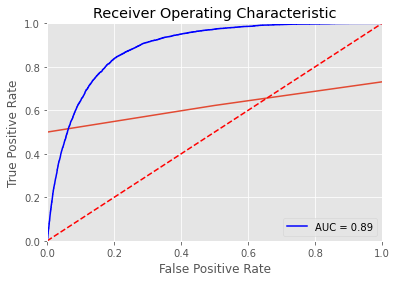

In [3]:
#Логистическая регрессия позволяет исседовать взаимосвязи для зависимой переменной с двумя значениями (0,1)
#Результирующая переменная в порядковой шкале
#При невозможности распознать классы их следует отбросить (укрупняя группировку)
#Критерии качества: #Accuracy (доля правильных ответов). Precision (точночть). Recall (полнота) ИЛИ
#AUC area under curve - общая площадь под кривой(один классификатор и множество пороговых значений)
#ROC reciever operator curve. FPR=FP/(FP+TP). Чем ближе точка в РОК кривой в классификаторе к TPR, тем лучше
#Пороговое значение управляет качеством классификатора. Например, можно увеличивать охват, но снижать долю

#Если несколько классов, но хочется сделать классификацию строго бинарной, то разбиваем на группы ДА и НЕТ
#df['Desired1(3)'] = df['Desired1(3)'].replace(0, 1)

x = np.array(np.arange(-10, 10, 0.5))
y = 1. / (1 + np.exp(-x))
plt.plot(x, y)
plt.title(u'Логистическая функция')

df = pd.read_csv('bank-full.csv', sep=';')
df = df.dropna()

#как распределены пропущенные значения 'unknown' по колонкам.
df.apply(lambda x: sum(x == 'unknown'), axis=0)

#Удалим самые пустые колонки полностью и выбросим строчки с пропущенными значениями в job и education
df = df.drop(['contact', 'poutcome'], axis=1)
df = df[(df['job'] != 'unknown') & (df['education'] != 'unknown')]
df.shape

print (df['education'].value_counts())
print (df['default'].value_counts())
print (df['housing'].value_counts())
print (df['loan'].value_counts())
print (df['y'].value_counts())

#Преобразуем бинарные столбцы в численные. Колонку y тоже
df['education'] = df['education'].map({'primary': 0, 'secondary': 1, 'tertiary': 2})
df['default'] = df['default'].map({'no': 0, 'yes': 1})
df['housing'] = df['housing'].map({'no': 0, 'yes': 1})
df['loan'] = df['loan'].map({'no': 0, 'yes': 1})
df['y'] = df['y'].map({'no': 0, 'yes': 1})

#Категориальные колонки не имеют естественного порядка, поэтому преобразуем их с помощью one-hot encoding
cat_features = ['job', 'marital', 'month']
df = pd.get_dummies(df, columns=cat_features)

#Разделяем на предикторы и отклик
X = df.drop('y', axis=1)
y = df['y']

#Создаем модель
model = LogisticRegression(    
    solver='liblinear', #метод для поиска решения. Для больших - sag и saga. Варианты: newton-cg, lbfgs
    penalty='l2', #норма для регуляризации. Варианты: l2, l1
    C=1, #параметр регуляризации. Чем меньше, тем сильнее регуляризация. Можно искать greedsearch
    tol=1e-4,  #параметр для остановки поиска решения.
    multi_class='ovr' #Уточняем, что всего 2 класса
    )

#Обучаем модель
model.fit(X, y)

#Для анализа предсказания результатов строим матрицу ошибок
preds = model.predict(X)
conf_mat = metrics.confusion_matrix(y, preds)
conf_mat = pd.DataFrame(conf_mat, index=model.classes_, columns=model.classes_)
conf_mat

#Смотрим результат рассчета вероятности
pred_prob = model.predict_proba(X)

#Рассчитываем РОК-кривую, указывая FPR, TPR
preds = pred_prob[:,1]
fpr, tpr, threshold = metrics.roc_curve(y, preds)
roc_auc = metrics.auc(fpr, tpr)

#Рисуем РОК-кривую
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [ ]:
#Вычисление статистической погрешности для случайной выборки

#Расчет объема выборки
N = 40000 #Генеральная совокупность
P = 0.95 #Доверительный уровень в 95% 
Z = 1.96 #коэффициент доверительного уровня (p = 95%, Z=1,96)(p=99%,   Z=2,58)
p = 0.5 #доля респондентов с  наличием исследуемого признака,
q = (1 - p) #доля респондентов, у которых исследуемый признак отсутствует,
delta = 0.05 #Задаваемая предельная ошибка выборки.
n = (Z**2)*p*q/delta**2 #объем выборки

print("Рекомендуемый объем выборки для данной аудитории:", int(n), "человек")

In [ ]:
#Расчет ошибки выбоки для доли признака
#Случай 1. Генеральная совокупность значительно больше выборки
n = 384 #Объем выборки
m = 276 #Число объектов выборки с нужными параметрами (True)
p = m/n #Вероятность на основе практических данных
sigma = n/2*((p*(1-p)/n*(1-n/N)))**0.5 
print('Результат выборки один составит: ', \
      float("{0:.1f}".format(p*100)), "±", float("{0:.1f}".format(sigma)), "%")

#Случай 2. Генеральная совокупность сопоставима с объемом выборки
N = 2500
delta = Z*((p*q/n)*((N-n)/(N-1)))**0.5 
print("Точность результатов выборки два составит: ", "±", float("{0:.1f}".format(delta*100)), "%")

In [ ]:
#Рассчет доверительного интервала
P = 0.99 #Доверительный уровень в 99% 
Z = 2.58 #коэффициент доверительного уровня 
p = 0.2 #доля респондентов с наличием исследуемого признака,
q = (1 - p) #доля респондентов, у которых исследуемый признак отсутствует,
n = 1000 #Объем выборки

sigma = Z*(p*q/n)**0.5 #Погрешность оценки

print('Точность результатов конкретной выборки составит: ±', float("{0:.2f}".format(sigma*100)), "%")
print('Доверительный интервал составит:', float("{0:.2f}".format((p - sigma)*100)), "% ;", \
                                            float("{0:.2f}".format((p + sigma)*100)), "%")